In [9]:
#Import Data from github repo
#Link to water ministry website [https://www.maji.go.tz/]
#Link to dataset by  [https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/]

#Importing the python library 
import pandas as pd
import category_encoders as ce
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
import numpy as np
from IPython.display import Image
from pylab import rcParams
import geopandas


features = 'https://raw.githubusercontent.com/mkirby1995/Tanzania_water_project/master/train_features.csv'
target = 'https://raw.githubusercontent.com/mkirby1995/Tanzania_water_project/master/train_labels.csv'
test = 'https://raw.githubusercontent.com/mkirby1995/Tanzania_water_project/master/test_features.csv'


#creating the panda dataframes
#Features are the dataframe containing the input variables for the model
features = pd.read_csv(features)
#Labels are the predction variables
labels = pd.read_csv(target)
#X_test is the test variables  
X_test = pd.read_csv(test)

#meging features and laebles to create single data frame based on index
df = features.merge(labels, on = features.index)

print("prediction variable \n",labels.columns)
print('\n')
print("feature variable \n",features.columns)



prediction variable 
 Index(['id', 'status_group'], dtype='object')


feature variable 
 Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'recorded_by',
       'scheme_management', 'scheme_name', 'permit', 'construction_year',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group'],
      dtype='object')


In [2]:
# Data Cleaning - filling out the missing values and zero values in the dataset 
# find out the missing values in the dataset
print(features.isna().sum())

# calculating the non zero mean of the distribution 
print("\nNon zero mean for the construction_year - " ,features['construction_year'][ features['construction_year'] != 0 ].mean() )
# replacing the zero vales for the construction year with non zero mean ie 1995
features['construction_year'] = features['construction_year'].replace({0:1995})


id                           0
amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_

In [3]:
#Feature Engineering 
# Feature engineering - calculating age of the pump 
features['age'] = features['date_recorded'].astype(str).str[:4].astype(int) - features['construction_year']
print("\nMean of the age of pump - ",features['age'].mean())

# Feature engineering - calculating the population served per year
features['pop/year'] = features['population'].replace({0:1}) / features['age'].replace({0:1})
print("\nMean of pop/year - ",features['pop/year'].mean())

# Feature engineering - calculating the water each person gets from water pump 
features['water_/_person'] = features['amount_tsh'].replace({0:1}) / features['population'].replace({0:1}) 
print("\nMean of water_/_person - ",features['water_/_person'].mean())

# Modifying the data for test dataset accordingly 
X_test['construction_year'] = X_test['construction_year'].replace({0:1993})
X_test['age'] = X_test['date_recorded'].astype(str).str[:4].astype(int) - X_test['construction_year']
X_test['pop/year'] = X_test['population'].replace({0:1}) / X_test['age'].replace({0:1})
X_test['water_/_person'] = X_test['amount_tsh'].replace({0:1}) / X_test['population'].replace({0:1})


Mean of the age of pump -  15.739646464646464

Mean of pop/year -  36.15715092829291

Mean of water_/_person -  70.35625816674902


In [15]:
# Encoding the features in the data for building data piplelines model using sklearn 
#   Using oneHotEncoding for low cardinality feature 
#   Using ordinal Encoding for High cardinality feature
#   Logic [if cardinality > 150 -> High cardinality else Low cardinality] 

# Function to check the cardinality [unique values] of the feature variables
def reverse_cardinality_check(n, df):
  feature_list = []
  cardinality_value = []

  for _ in range(len(df.columns)):
    if len(df[df.columns[_]].value_counts()) > n:
      feature_list.append(df.columns[_])
      cardinality_value.append(len(df[df.columns[_]].value_counts()))

  feature_dict = dict(zip(feature_list, cardinality_value))

  return feature_dict

# creating data frames for high cardinality and low cardinality features for encoding 
# Bifuracting high cardinality features and [checking columns more than 150 unique values  ]
high_cardinality_feature_dict = reverse_cardinality_check(150, features)
high_cardinality_features = features[list(high_cardinality_feature_dict.keys())]
high_cardinality_features.columns
print("\n High Cardinality features -\n ",high_cardinality_feature_dict)

# Bifurcating low cardinality features
low_cardinality_features = features.drop(columns = list(high_cardinality_feature_dict.keys()))
print("\n Low Cardinality features -\n ",low_cardinality_features.columns)

#Encoding the low and high cardinality features 
one_hot_encode = ce.OneHotEncoder(use_cat_names=True)
one_hot_encode.fit(low_cardinality_features, labels['status_group'])
low_cardinality_features = one_hot_encode.transform(low_cardinality_features)

ordinal_encode = ce.OrdinalEncoder()
ordinal_encode.fit(high_cardinality_features, labels['status_group'])
high_cardinality_features = ordinal_encode.transform(high_cardinality_features)


# Merging both cardinality back into feature dataset
features = low_cardinality_features.merge(high_cardinality_features,on = low_cardinality_features.index)

feature_names = features.columns
print("\n features columns -\n ",feature_names)


 High Cardinality features -
  {'id': 59400, 'date_recorded': 356, 'funder': 1897, 'gps_height': 2428, 'installer': 2145, 'longitude': 57516, 'latitude': 57517, 'wpt_name': 37400, 'subvillage': 19287, 'ward': 2092, 'population': 1049, 'scheme_name': 2696}

 Low Cardinality features -
  Index(['amount_tsh', 'num_private', 'basin', 'region', 'region_code',
       'district_code', 'lga', 'public_meeting', 'recorded_by',
       'scheme_management', 'permit', 'construction_year', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'management',
       'management_group', 'payment', 'payment_type', 'water_quality',
       'quality_group', 'quantity', 'quantity_group', 'source', 'source_type',
       'source_class', 'waterpoint_type', 'waterpoint_type_group'],
      dtype='object')
C:\Users\dhava\anaconda3\envs\poseidon\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categori

In [16]:
# Imputing [imputation is replacing missing data with substituted values in my case it is mean ]
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer.fit(features, labels['status_group'])
features = imputer.transform(features)


In [17]:
# Scaling the features [https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html]
scaler = RobustScaler()
scaler.fit(features, labels['status_group'])
features = scaler.transform(features)

In [18]:
# Performing the encoding, Imputing and scaling for the test dataset
high_cardinality_X_test_dict = reverse_cardinality_check(150, X_test)
low_cardinality_X_test = X_test.drop(columns = list(high_cardinality_X_test_dict.keys()))
high_cardinality_X_test = X_test[list(high_cardinality_X_test_dict.keys())]
low_cardinality_X_test = one_hot_encode.transform(low_cardinality_X_test)
high_cardinality_X_test = ordinal_encode.transform(high_cardinality_X_test)
X_test = low_cardinality_X_test.merge(high_cardinality_X_test,on = low_cardinality_X_test.index)
X_test = imputer.transform(X_test)
X_test = scaler.transform(X_test)

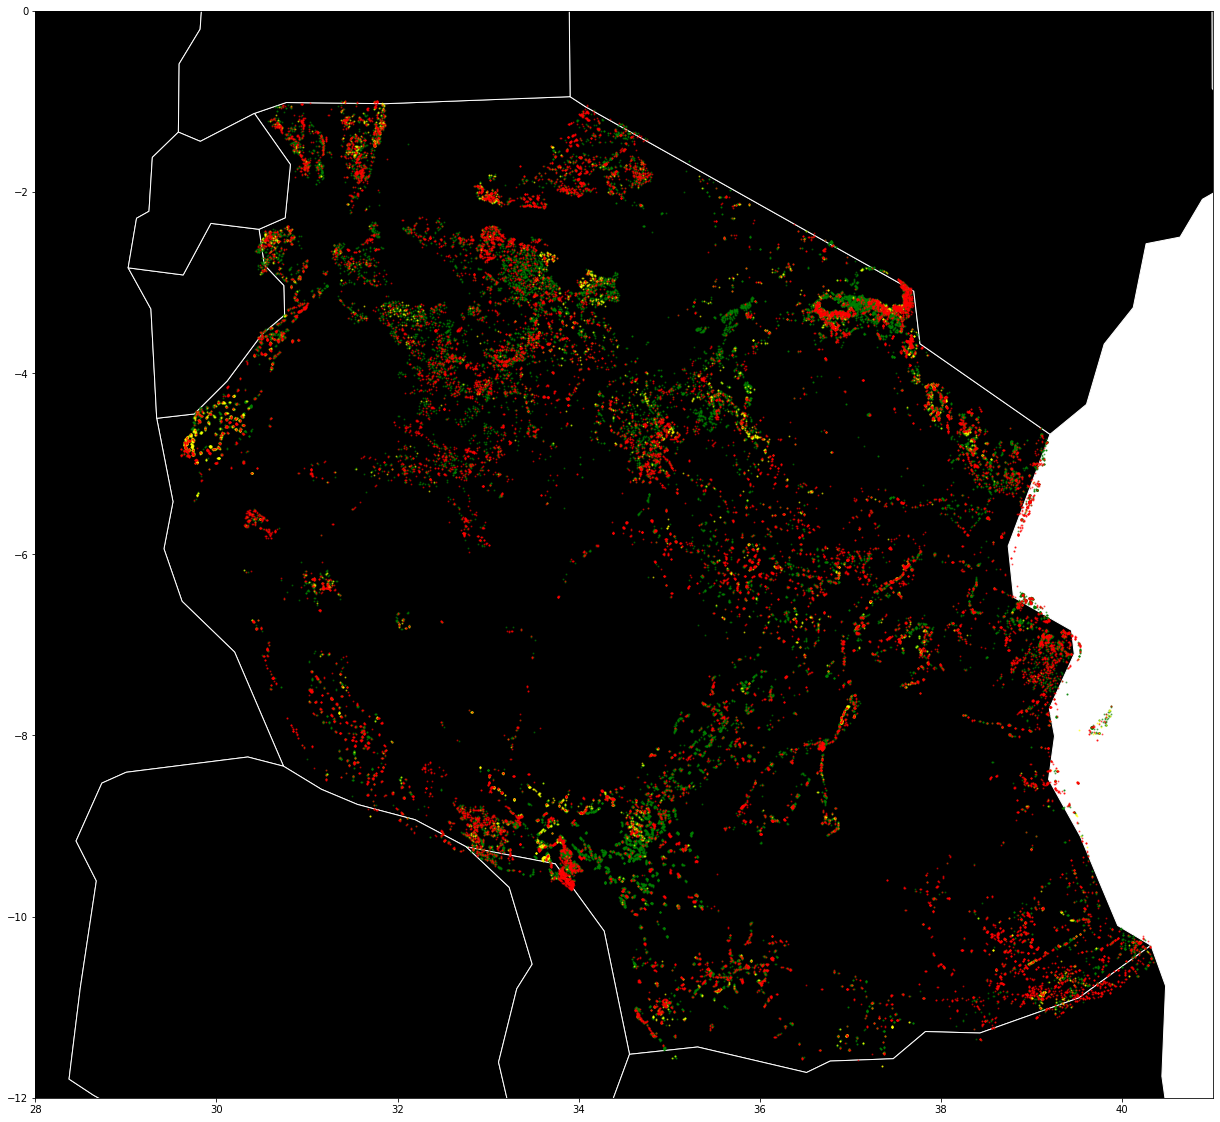

In [33]:
#Ploting the map based on longitude and latitude using geopandas library 
# [Reference https://blog.cambridgespark.com/managing-spatial-data-using-geopandas-in-python-8e70c646f708]
# Red - non functional
# green - functional
# Yellow - functional but need service 

rcParams['figure.figsize'] = 30, 20

gdf = geopandas.GeoDataFrame(df, geometry=geopandas.points_from_xy(df.longitude, df.latitude))
#dividing gdf into 3 sections 
functional = gdf.where(gdf['status_group'] == 'functional')
repair = gdf.where(gdf['status_group'] == 'functional needs repair')
broken = gdf.where(gdf['status_group'] == 'non functional')

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

#Ploting the base plot of the map of Tanzania 
ax = world[world.continent == 'Africa'].plot(color='black', edgecolor='white')

ax.scatter(functional['longitude'], functional['latitude'],c='green',alpha=.5, s=1)
ax.scatter(repair['longitude'], repair['latitude'],c='yellow', alpha=.5, s=1)
ax.scatter(broken['longitude'], broken['latitude'],c='red', alpha=.5, s=1)

# For adjusting the base plot map 
plt.ylim(-12, 0)
plt.xlim(28,41)

plt.show()


In [20]:
# CREATING THE MODEL USING RANDOM FOREST CLASSIFIER 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

#Traing the random classifier model
#x_Matrix represents the input variables as input variable for the model
#Y_Matrix represents the prediction variable as output varible for the model
X_matrix, y_vector = features, labels['status_group']
param_distributions = {
    'max_depth': [25, 26, 27, 28, 29]
}

#Building the random forest archietecture (gridsearch) with parameters 
gridsearch = RandomizedSearchCV(
    RandomForestClassifier(n_estimators=92, n_jobs=-1, random_state=42), 
    param_distributions=param_distributions, 
    n_iter=5, 
    cv=5, 
    scoring='accuracy', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1
)

gridsearch.fit(X_matrix, y_vector)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   42.0s
[Parallel(n_jobs=-1)]: Done   5 out of  25 | elapsed:   43.8s remaining:  2.9min
[Parallel(n_jobs=-1)]: Done   8 out of  25 | elapsed:   43.9s remaining:  1.6min
[Parallel(n_jobs=-1)]: Done  11 out of  25 | elapsed:   45.0s remaining:   57.3s
[Parallel(n_jobs=-1)]: Done  14 out of  25 | elapsed:  1.5min remaining:  1.1min
[Parallel(n_jobs=-1)]: Done  17 out of  25 | elapsed:  1.5min remaining:   41.8s
[Parallel(n_jobs=-1)]: Done  20 out of  25 | elapsed:  1.5min remaining:   22.2s
[Parallel(n_jobs=-1)]: Done  23 out of  25 | elapsed:  1.5min remaining:    7.7s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  1.6min finished


RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(n_estimators=92, n_jobs=-1,
                                                    random_state=42),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'max_depth': [25, 26, 27, 28, 29]},
                   return_train_score=True, scoring='accuracy', verbose=10)

Best result from search of 5 parameter combinations
                precision    recall  f1-score   support

    Functional       0.98      1.00      0.99     32259
  Needs Repair       1.00      0.96      0.98      4317
Not-Functional       1.00      0.99      0.99     22824

      accuracy                           0.99     59400
     macro avg       0.99      0.98      0.99     59400
  weighted avg       0.99      0.99      0.99     59400



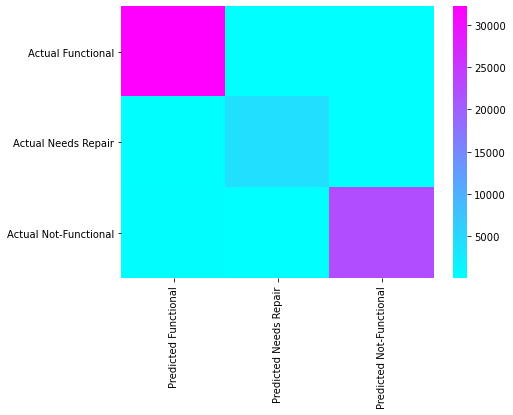

Predicted Functional  Predicted Needs Repair  \
Actual Functional                     32250                       1   
Actual Needs Repair                     187                    4123   
Actual Not-Functional                   327                       1   

                       Predicted Not-Functional  
Actual Functional                             8  
Actual Needs Repair                           7  
Actual Not-Functional                     22496

In [32]:
results = pd.DataFrame(gridsearch.cv_results_)
print(f'Best result from search of {len(results)} parameter combinations')
results.sort_values(by='rank_test_score').head(5)
model = gridsearch.best_estimator_
  

#Confusion matrix code
from sklearn.model_selection import cross_validate
from sklearn.metrics import classification_report, confusion_matrix

rcParams['figure.figsize'] = 7, 5
def con_matrix_analysis(model):
  x = model.predict(features)
  y = y_vector
  
  print(classification_report(y, x,
        target_names=['Functional', 'Needs Repair', 'Not-Functional']))

  con_matrix = pd.DataFrame(confusion_matrix(y, x), 
             columns=['Predicted Functional', 'Predicted Needs Repair', 'Predicted Not-Functional'], 
             index=['Actual Functional', 'Actual Needs Repair', 'Actual Not-Functional'])
                            
  sns.heatmap(data=con_matrix, cmap='cool')
  plt.show();
  return con_matrix

con_matrix_analysis(model)

In [36]:
#Pickle the model for the django package 
pd.to_pickle(model,r'Random_forest_Water_Pump_prediction.pickle')